In [1]:
# from https://github.com/cran/GSA/blob/master/R/GSA.read.gmt.R
GSA.read.gmt = function(filename){
    # Read in and parse a gmt file (gene set file) from the  Broad institute
    # this is tricky, because each lines (geneset) has a variable length
    #  I read the file twice, first to pick up the geneset name and description
    # in the   first two  columns, then I read it all in as a long string

    # The beginning and end of each gene set in the string
    # is determined by matching
    # BOTH on  geneset name and description (since geneset names sometimes
    # occur as genenames elsewhere in the file)

    a = scan(filename,what = list("",""),sep = "\t", quote = NULL, fill = T, flush = T,multi.line = F)
    geneset.names = a[1][[1]]

    geneset.descriptions = a[2][[1]]

    dd = scan(filename,what = "",sep = "\t", quote = NULL)


    nn = length(geneset.names)
    n = length(dd)
    ox = rep(NA,nn)

    ii = 1
    for(i in 1:nn){
        while((dd[ii] != geneset.names[i]) | (dd[ii+1] != geneset.descriptions[i]) ){
            ii = ii+1
        }
        ox[i] = ii
        ii = ii+1
    }

    genesets = vector("list",nn)

    for(i in 1:(nn-1)){
        i1 = ox[i]+2
        i2 = ox[i+1]-1
        geneset.descriptions[i] = dd[ox[i]+1]
        genesets[[i]] = dd[i1:i2]
    }

    geneset.descriptions[nn] = dd[ox[nn]+1]
    genesets[[nn]] = dd[(ox[nn]+2):n]
    out = list(genesets = genesets,geneset.names = geneset.names, geneset.descriptions = geneset.descriptions)
    class(out) = "GSA.genesets"
    return(out)
}

fisher.intersect <- function(gs, switches){
    pi <- switches %>%
        filter(PPI == 1) %>%
        .$GeneId %>%
        intersect(gs) %>% 
        length
    po <- switches %>%
        filter(PPI == 1) %>%
        .$GeneId %>%
        setdiff(., gs) %>% 
        length
    npi <- length(gs) - pi
    npo <- nrow(switches) - (pi + po + npi)
    
    m <- c(pi,po,npi,npo) %>% matrix(2,2)
    f <- m %>% fisher.test(alternative = "greater")
    em <- m + 0.5
    eOR <- (em[1,1]*em[2,2])/(em[1,2]*em[2,1])
    
    data.frame(p = f$p.value, OR = f$estimate, eOR = eOR,
               switched = switches %>% filter(GeneId %in% gs) %>% .$Symbol %>% unique %>% 
                           sort %>% paste(collapse = ","))
    
}

ppi.stats <- function(gs, switches, ppi, ppi.driver){
    
    ppi.with.d0 <- id2symbol %>%
        filter(GeneId %in% c(intersect(gs,ppi.driver$GeneId),intersect(gs,ppi.driver$partnerGeneId))) %>% 
        .$Symbol %>%
        unique %>%
        sort %>%
        paste(collapse = ",")
        
    two.coding <- switches %>%
        filter(CDS_Normal == 1 & CDS_Tumor == 1) %>%
        filter(GeneId %in% gs) %>%
        merge(ppi) %>%
        .$Symbol %>%
        unique %>%
        sort %>%
        paste(collapse = ",")
    
    data.frame(driverAffected = ppi.with.d0, twoCoding = two.coding)
    
}

In [2]:
source("../data/env/variables.R")
source("~/projects/wisdom/r/data_analysis_environment.R")
source("~/projects/wisdom/r/clean_theme.R")

options("readr.num_columns" = 0)

# read switches that affect PPIs
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor" & PPI == 1)

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")
    
potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

# unique genes from the proteome
allGenes <- read_tsv("../data/mutations/proteome_information.txt") %>%
    filter(asEvidence=="True") %>%
    select(GeneId,Symbol) %>%
    unique

id2symbol <- read_tsv("../data/mutations/proteome_information.txt") %>%
    select(GeneId,Symbol) %>%
    unique

# unique drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
    set_colnames(c("Symbol","Tumor")) %>%
    .$Symbol %>%
    unique

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    mutate(asEvidence = as.numeric(asEvidence=="True"))
        
# read interactions
ppi.network <- read_tsv("../data/eporta/raw_tables/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))
    
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = plyr::revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))
    
ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,GeneId.partner,partnerSymbol) %>%
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript",
                   "partnerGeneId","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > Loss, "Gain", Tag)) %>%
    merge(switches)
        
ppi.driver <- ppi %>%
    filter( Symbol %in% drivers | partnerSymbol %in% drivers ) %>%
    filter( Loss != 0 | Gain != 0)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“attributes are not identical across measure variables; they will be dropped”

# Canonical pathways

In [3]:
# read gene sets
canonical.patways.raw <- GSA.read.gmt("../data/genesets/c2.cp.v4.0.entrez.gmt")

canonical.patways <- canonical.patways.raw$genesets
names(canonical.patways) <- canonical.patways.raw$geneset.names

# calculate bilateral fisher test
cp.fisher <- lapply(canonical.patways, fisher.intersect, switches) %>% 
    do.call("rbind", .) %>%
    mutate(adjp = p.adjust(p))

cp.stats <- lapply(canonical.patways, ppi.stats, switches, ppi, ppi.driver) %>% 
    do.call("rbind", .) %>%
    mutate(geneset = names(canonical.patways),
           # count the number of drivers in each gene set
           NumDrivers = lapply(canonical.patways, function(gs){
               id2symbol %>% filter(Symbol %in% drivers) %>% .$GeneId %>% intersect(gs) %>% length
           }) %>% do.call("c",.) )

canonical.patways.test <- cbind(cp.stats, cp.fisher)

canonical.patways.test %>%
    write_tsv("../results/networks/canonical_patways_test.tsv")

Loading required package: RColorBrewer


[1] 4

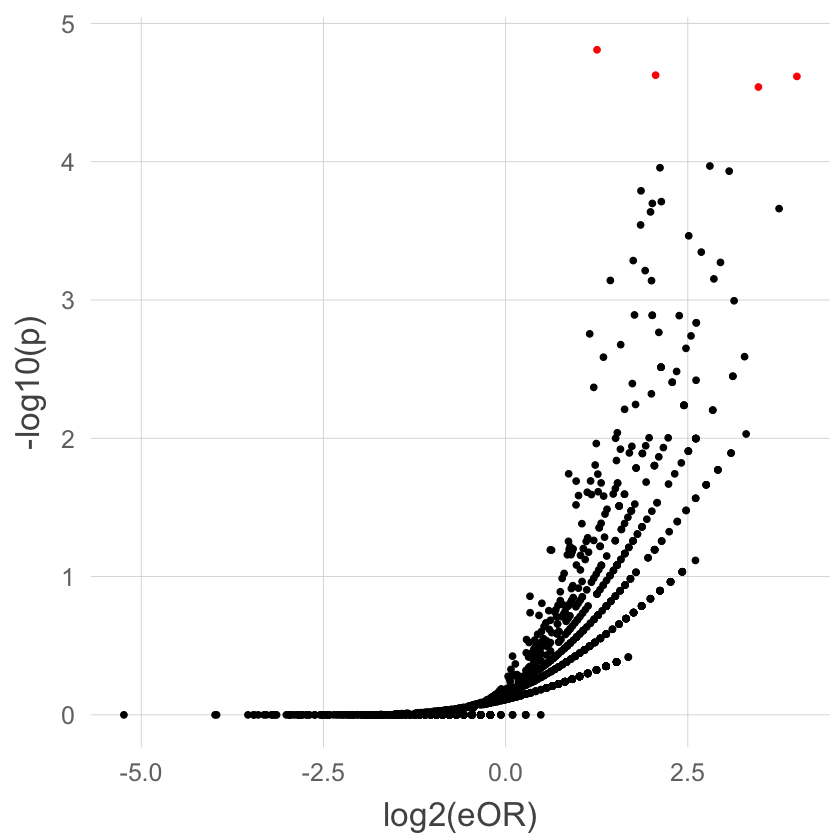

In [4]:
# volcano plot
ggplot() + 
    geom_point(data = subset(canonical.patways.test, adjp > 0.05 | eOR < 1), aes(x = log2(eOR), y = -log10(p))) +
    geom_point(data = subset(canonical.patways.test, adjp < 0.05 & eOR > 1), aes(x = log2(eOR), y = -log10(p)), 
               color = "red") +
    clean_theme()

subset(canonical.patways.test, adjp < 0.05 & eOR > 1) %>% nrow

In [5]:
# canonical patways enriched in ppi switches with two coding isoforms
canonical.patways.test %>%
    filter(adjp < 0.05 & eOR > 1 & driverAffected != "" & twoCoding != "") %>%
    arrange(desc(NumDrivers)) %>%
    select(geneset,eOR,twoCoding)

geneset,eOR,twoCoding
KEGG_PATHWAYS_IN_CANCER,2.385431,"AR,ARNT,BCL2L1,CASP9,CCNE1,CDKN2A,CDKN2B,CTBP1,EPAS1,FGFR1,GRB2,HIF1A,LAMA1,LAMB1,MAX,MDM2,MLH1,PDGFRA,PIAS3,PPARD,PTK2,RARA,SKP2,SOS2,STK36"
KEGG_SMALL_CELL_LUNG_CANCER,4.165890,"APAF1,BCL2L1,CASP9,CCNE1,CDKN2B,LAMA1,LAMB1,MAX,PIAS3,PTK2,SKP2"
SA_CASPASE_CASCADE,11.074430,"APAF1,CASP9"
REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS,15.968463,"CFLAR,RIPK1,TNF"


# Complexes

In [6]:
complexes.raw <- read_delim("../data/genesets/allComplexes.csv", delim = ";") %>%
    set_colnames(c("id","name","synonym","organism","uniprots","geneids","method",
                   "pmid","FunCat.categories","functional.comment","disease.comment","subunit.comment")) %>%
    filter(organism == "Human") %>% 
    select(name,geneids)

complexes <- complexes.raw %>%
    apply(1, function(x) strsplit(x[2], ",") %>% unlist) %>%
    set_names(complexes.raw$name)

# calculate bilateral fisher test
c.fisher <- lapply(complexes, fisher.intersect, switches) %>% 
    do.call("rbind", .) %>%
    mutate(adjp = p.adjust(p))

c.stats <- lapply(complexes, ppi.stats, switches, ppi, ppi.driver) %>% 
    do.call("rbind", .) %>%
    mutate(geneset = names(complexes),
           # count the number of drivers in each gene set
           NumDrivers = lapply(complexes, function(gs){
               id2symbol %>% filter(Symbol %in% drivers) %>% .$GeneId %>% intersect(gs) %>% length
           }) %>% do.call("c",.) )

complexes.test <- cbind(c.stats, c.fisher) %>%
    filter(switched != "") 
        
cbind(c.stats, c.fisher) %>%
    write_tsv("../results/networks/complexes_test.tsv")

Warning message:
“Missing column names filled in: 'X13' [13]”Warning message:
“2895 parsing failures.
row col   expected     actual
  1  -- 13 columns 12 columns
  2  -- 13 columns 12 columns
  3  -- 13 columns 12 columns
  4  -- 13 columns 12 columns
  5  -- 13 columns 12 columns
... ... .......... ..........
See problems(...) for more details.
”

[1] 0

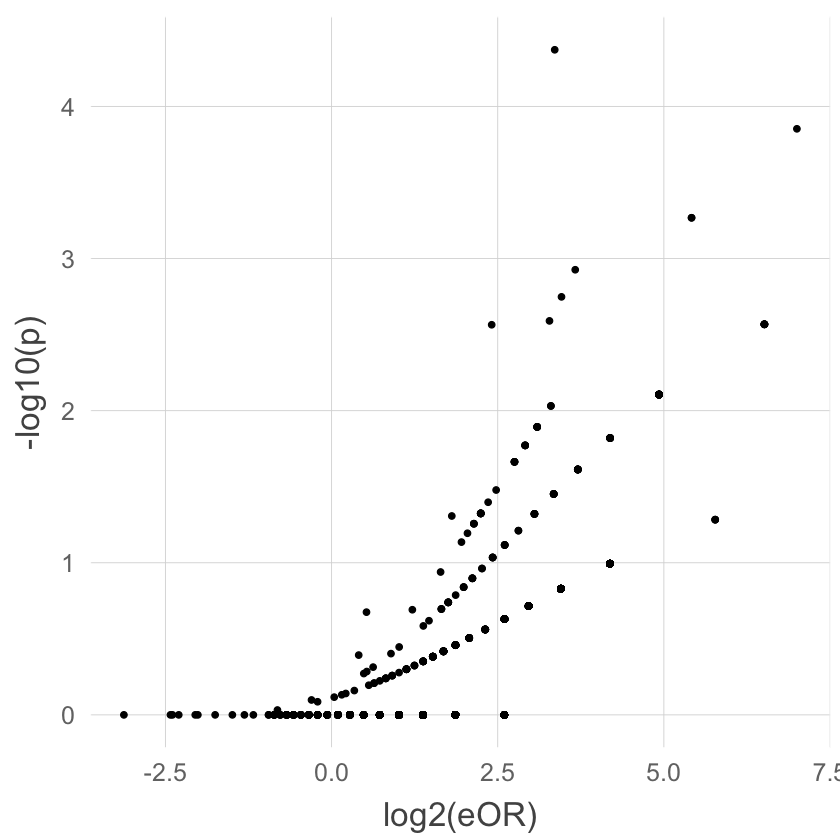

In [7]:
# volcano plot
ggplot() + 
    geom_point(data = subset(complexes.test, adjp > 0.05 | eOR < 1), aes(x = log2(eOR), y = -log10(p))) +
    geom_point(data = subset(complexes.test, adjp < 0.05 & eOR > 1), aes(x = log2(eOR), y = -log10(p)), 
               color = "red") +
    clean_theme()

subset(complexes.test, adjp < 0.05 & eOR > 1) %>% nrow

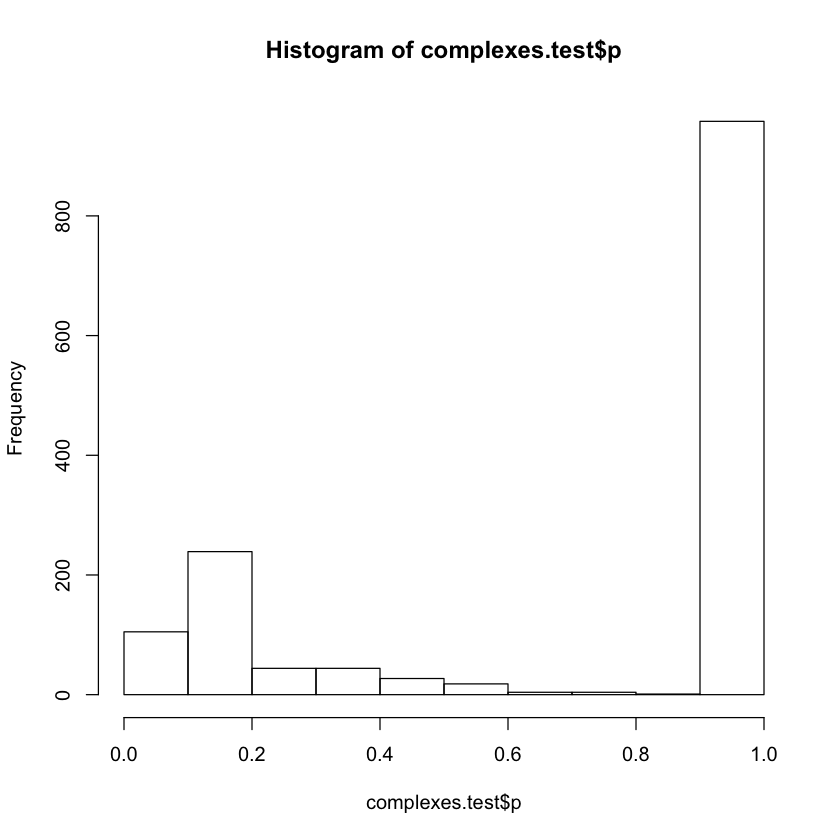

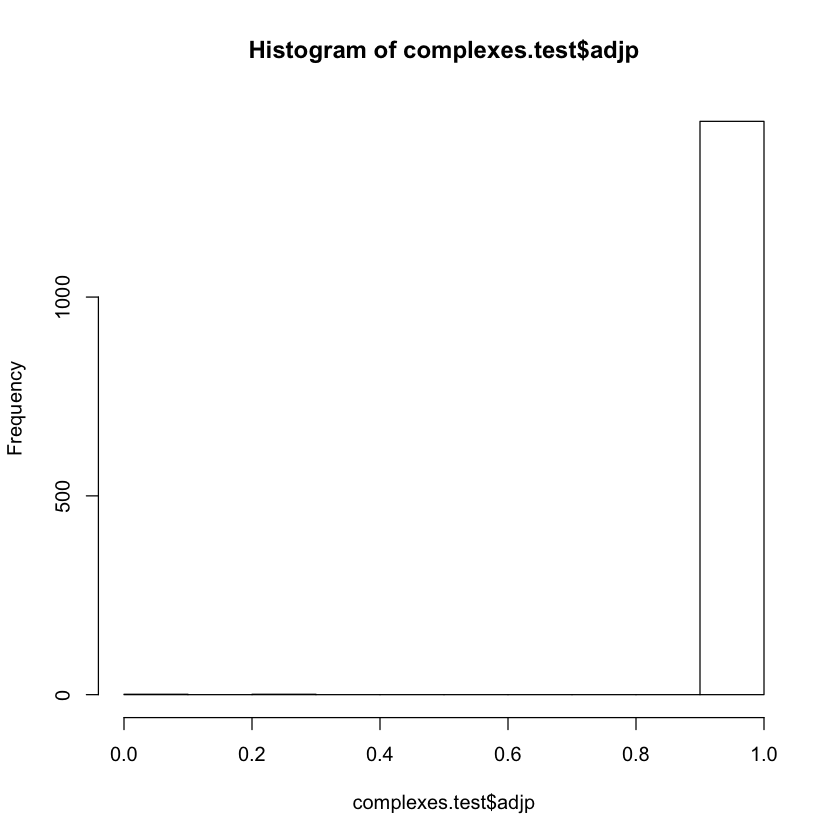

In [8]:
hist(complexes.test$p)
hist(complexes.test$adjp)

In [9]:
complexes.test %>%
    filter(p < 0.05 & eOR > 1 & driverAffected != "" & twoCoding != "") %>%
    arrange(desc(NumDrivers)) %>%
    select(geneset,eOR,twoCoding)

geneset,eOR,twoCoding
ALL-1 supercomplex,5.312442,"MTA2,SMARCA2,TAF1,TAF6,TAF9"
Large Drosha complex,10.252768,"DDX17,DHX15,FUS,HNRNPU,ILF3"
BASC (Ab 81) complex (BRCA1-associated genome surveillance complex),10.143008,"BRCA1,MLH1"
MLL1-WDR5 complex,3.504096,"TAF1,TAF6,TAF9"
SWI-SNF chromatin remodeling-related-BRCA1 complex,7.531720,"BRCA1,SMARCA2"
E2F-6 complex,6.738031,"EHMT2,MAX"
WINAC complex,5.564752,"SMARCA2,TOP2B"
MOF complex,12.696709,"TAF1,TAF6,TAF9"
DGCR8 multiprotein complex,11.002384,"DDX17,FUS,HNRNPU,ILF3"
p300-MDM2-p53 protein complex,30.440886,MDM2


# mRNA regulation

In [10]:
mrna.raw <- read_tsv("../data/genesets/akerman.csv")

mrna <- apply(mrna.raw, 1, function(x){
            genes <- strsplit(x[2], ",") %>% unlist %>% sub("^\\s+", "", .)
            id2symbol %>%
                filter(Symbol %in% genes) %>% 
                .$GeneId
        } ) %>% set_names(mrna.raw$Category)

# calculate bilateral fisher test
m.fisher <- lapply(mrna, fisher.intersect, switches) %>% 
    do.call("rbind", .) %>%
    mutate(adjp = p.adjust(p))

m.stats <- lapply(mrna, ppi.stats, switches, ppi, ppi.driver) %>% 
    do.call("rbind", .) %>%
    mutate(geneset = names(mrna),
           # count the number of drivers in each gene set
           NumDrivers = lapply(mrna, function(gs){
               id2symbol %>% filter(Symbol %in% drivers) %>% .$GeneId %>% intersect(gs) %>% length
           }) %>% do.call("c",.) )

mrna.test <- cbind(m.stats, m.fisher)

mrna.test %>%
    write_tsv("../results/networks/mrna_test.tsv")

[1] 0

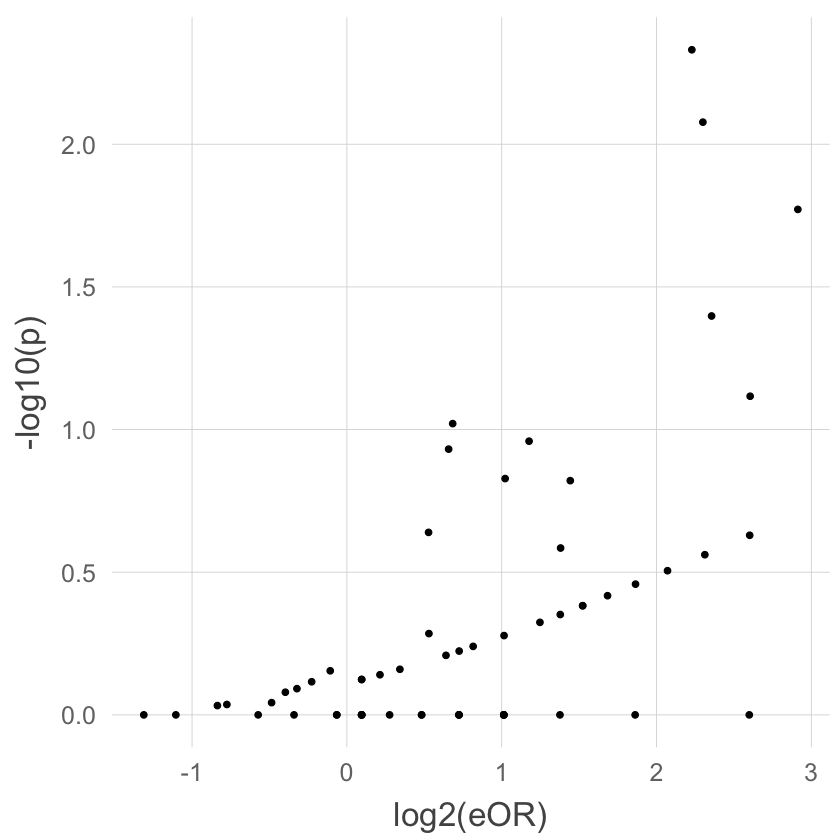

In [11]:
# volcano plot
ggplot() + 
    geom_point(data = subset(mrna.test, adjp > 0.05 | eOR < 1), aes(x = log2(eOR), y = -log10(p))) +
    geom_point(data = subset(mrna.test, adjp < 0.05 & eOR > 1), aes(x = log2(eOR), y = -log10(p)), 
               color = "red") +
    clean_theme()

subset(mrna.test, adjp < 0.05 & eOR > 1) %>% nrow

In [12]:
mrna.test %>%
    filter(p < 0.05 & eOR > 1 & driverAffected != "" & twoCoding != "") %>%
    arrange(desc(NumDrivers)) %>%
    select(geneset,eOR,twoCoding)

geneset,eOR,twoCoding
A Complex specific factors,5.118906,"CDK13,FUS,RBM25"
hnRNP,4.685617,"FUS,HNRNPC,HNRNPU,MSL1,RBMX"
Common spliceosomal components,4.923187,"HNRNPC,HNRNPU,ILF3,RBMX"
translation-related,7.531720,"EEF1A1,EIF2B5"


# Plot all significant networks

In [13]:
source("../data/env/getPPINetwork.R")
library(ggnetwork)
source("~/projects/wisdom/r/clean_theme.R")

ppiPalette = c("Gain" = "#31a354", "Loss" = "#f03b20", "Unaffected" = "#d9d9d9", "Draw" = "#d9d9d9")

cp <- canonical.patways.test %>%
    filter(adjp < 0.05 & eOR > 1 & driverAffected != "" & twoCoding != "") %>%
    .$geneset %>%
    canonical.patways[.]

c <- complexes.test %>%
    filter(p < 0.01 & eOR > 1 & driverAffected != "" & twoCoding != "") %>%
    .$geneset %>%
    complexes[.]

m <- mrna.test %>%
    filter(p < 0.01 & eOR > 1 & driverAffected != "" & twoCoding != "") %>%
    .$geneset %>%
    mrna[.]
 
sign.sets <- c(cp,c,m) 
e <- lapply(seq_along(sign.sets), function(i){
    
    gs <- sign.sets[[i]]
    gs.name <- names(sign.sets)[[i]]
    
    nw <- getPPINetwork(gs, ppi.network, ppi)
    nw %v% "Gene" <- ifelse(nw %v% "vertex.names" %in% drivers, "Driver", "Non-driver")
    
    tryCatch({    
        nw.plot <- ggplot(nw, aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(aes(color = Effect, linetype = Consensus)) +
            geom_nodelabel(aes(label = vertex.names, fill = Gene), size = 5, color = "white") +
            scale_color_manual(values = ppiPalette) +
            scale_fill_manual(values = c("Driver" = "black", "Non-driver" = "gray")) +
            scale_linetype_manual(values = c("Yes" = "solid", "No" = "dashed")) +
            lims( x = c(-.10, 1.10)) + 
            theme_minimal() +
            theme(axis.line=element_blank(),axis.text.x=element_blank(),
                  axis.text.y=element_blank(),axis.ticks=element_blank(),
                  axis.title.x=element_blank(),axis.title.y=element_blank(),
                  legend.position="bottom")

            ggsave(paste0("../results/networks/",gs.name,".png"), nw.plot)},
        error = function(e) e)
        
})

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘igraph’

The following objects are masked from ‘package:network’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    